In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
%matplotlib inline

import re
from datetime import datetime, date, timedelta
import warnings
warnings.filterwarnings('ignore')

import talib

In [2]:
# Take a look the index
df_ind = pd.read_excel('Index/SP500 tickets.xlsx')
df_ind2 = pd.read_csv('Index/Stocks in the SP 500 Index.csv')

df_ind.columns = [col.replace(u'\xa0', u' ') for col in df_ind.columns]

In [3]:
# Randomly Sample 5 stocks and get their stock price
# stocks = list(df_ind['Symbol'].sample(5, random_state = 7600))

# Get all ticker price
stocks = df_ind['Symbol'].unique()

# Standardize the column names
cols = ['report_date', 'open', 'high', 'low', 'close', 'volume', 'adjusted_close']

# Stock Price Data for the above 5 stocks
df_price = pd.DataFrame()

for stock in stocks:
    
    # Read the csv
    temp = pd.read_csv(f'Stock Price/{stock}_2022-07-31.csv')
    temp.columns = cols
    temp['ticker'] = stock
    
    # Represented by % Change
    for col in ['open', 'high', 'low', 'close', 'volume', 'adjusted_close']:
        temp[col] = (temp[col] - temp[col].iloc[0]) / temp[col].iloc[0]
    
    # Append to the stock price data
    df_price = df_price.append(temp)

BRK-B


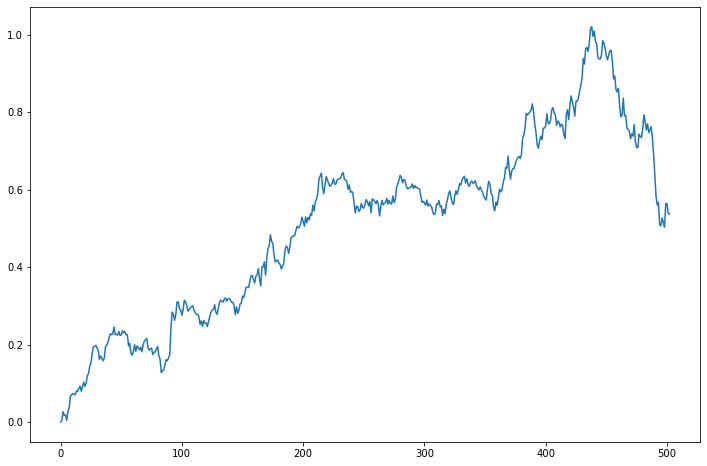

In [4]:
# Visualize the stock price
np.random.choice(7600)
stock = np.random.choice(stocks)
print(stock)

temp = df_price[df_price['ticker'] == stock]

fig = plt.figure(figsize=(12,8))
plt.plot(temp['close'])

fig.show()

BRK-B


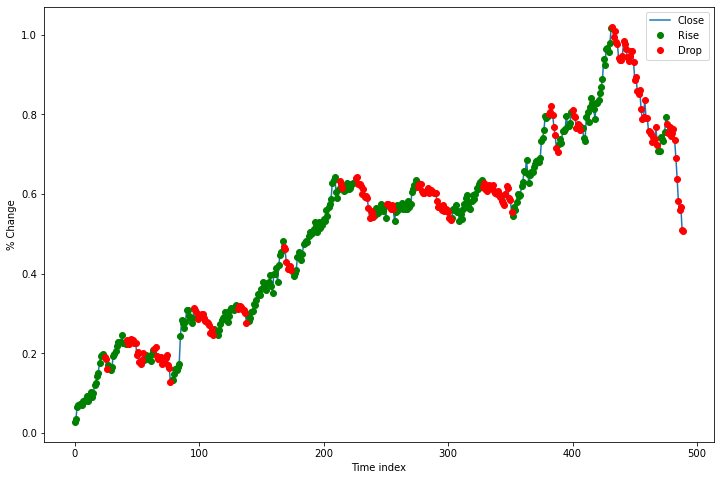

In [5]:
# Using Slop-detection method (using close)
# Reference: Short-Term Stock Price-Trend Prediction Using Meta-Learning
K = 7
temp['avg_close_before'] = temp['close'].rolling(K).mean()
temp['avg_close_after'] = temp['close'].shift(-K).rolling(K).mean()
temp['slope'] = temp['avg_close_after'] - temp['avg_close_before']
temp = temp.dropna().reset_index(drop = True)

# Label the Slope
temp['label'] = temp['slope'].apply(lambda x: 'rise' if x > 0 else 'drop')

# Visualize the ts with label
print(stock)
fig = plt.figure(figsize=(12,8))
temp_rise = temp[temp['label'] == 'rise']
temp_drop = temp[temp['label'] == 'drop']

plt.plot(temp['close'], label = 'Close')
plt.plot(temp_rise.index, temp_rise['close'], 'go', label = 'Rise')
plt.plot(temp_drop.index, temp_drop['close'], 'ro', label = 'Drop')
plt.legend()
plt.xlabel('Time index')
plt.ylabel('% Change')

fig.show()

11.212820809797726

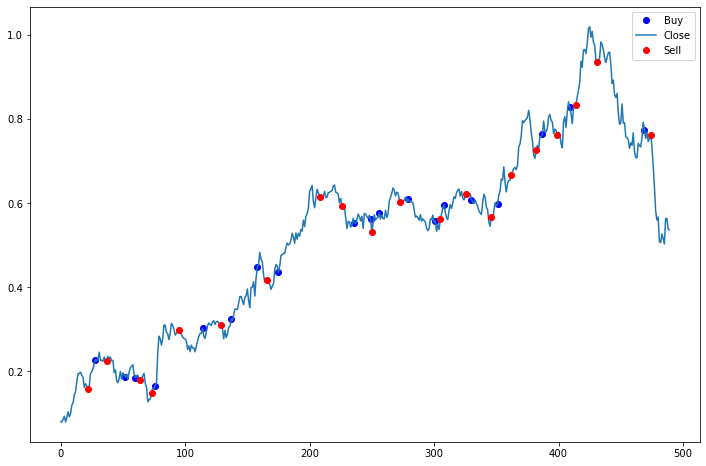

In [6]:
# Buy Hold Sell
# Ref: Sector influence aware stock trend prediction using 3D convolutional neural network
temp = df_price[df_price['ticker'] == stock]

window_size = 14
def labeling(arr):
    
    max_idx = arr.argmax()
    min_idx = arr.argmin()
    
    if max_idx == window_size // 2:
        return -1
    elif min_idx == window_size // 2:
        return 1
    else:
        return 0

label_mapping = {
    1: 'Buy',
    0: 'Hold',
    -1: 'Sell'
}
    
temp['label_int'] = temp['close'].rolling(window_size).apply(labeling)
temp = temp.dropna()
temp['label'] = temp['label_int'].apply(lambda x: label_mapping[x])
temp = temp.reset_index(drop = True)

fig = plt.figure(figsize = (12, 8))
temp_buy = temp[temp['label'] == 'Buy']
temp_hold = temp[temp['label'] == 'Hold']
temp_sell = temp[temp['label'] == 'Sell']

plt.plot(temp_buy.index, temp_buy['close'], "bo", label = 'Buy')
plt.plot(temp['close'], label = 'Close')
plt.plot(temp_sell.index, temp_sell['close'], "ro", label = 'Sell')
plt.legend()

# Test
bal = 10

for _, row in temp.iterrows():
    label = row['label']
    close = row['close']
    
    if label == 'Buy':
        bal -= close
    elif label == 'Sell':
        bal += close
bal

BRK-B


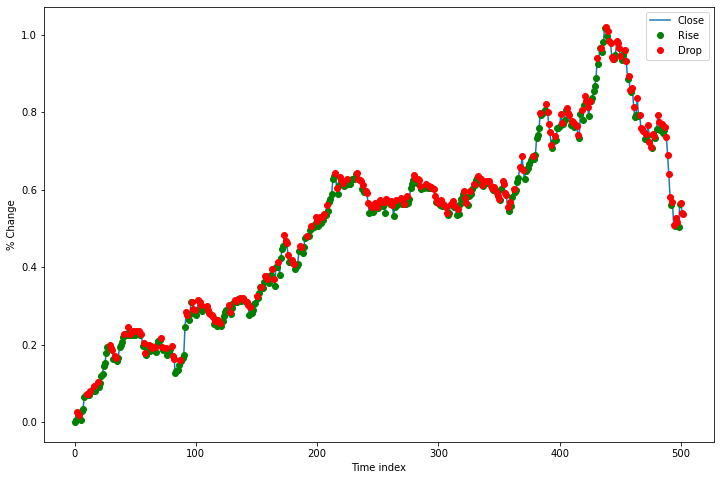

In [7]:
# Next one day trend
# DCP - A Framework Toward Forecasting the Price Movement from Candlestick Charts
period = 1
temp = df_price[df_price['ticker'] == stock]
temp[f'next_{period}_close'] = temp['close'].shift(-period)
temp['changes'] = temp[f'next_{period}_close'] - temp['close']
temp['label'] = temp['changes'].apply(lambda x: 'rise' if x > 0 else 'drop')

# Visualize the ts with label
print(stock)
fig = plt.figure(figsize=(12,8))
temp_rise = temp[temp['label'] == 'rise']
temp_drop = temp[temp['label'] == 'drop']

plt.plot(temp['close'], label = 'Close')
plt.plot(temp_rise.index, temp_rise['close'], 'go', label = 'Rise')
plt.plot(temp_drop.index, temp_drop['close'], 'ro', label = 'Drop')
plt.legend()
plt.xlabel('Time index')
plt.ylabel('% Change')

fig.show()

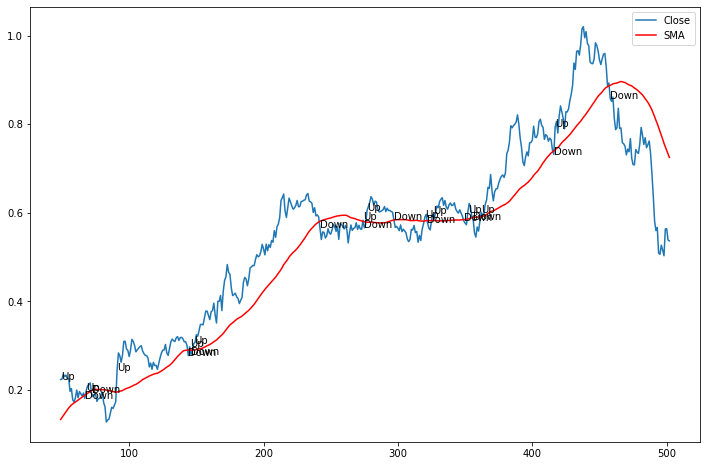

In [8]:
temp = df_price[df_price['ticker'] == stock]
temp['sma'] = talib.SMA(temp['close'], 50)

temp['close_gt_sma'] = temp['close'] > temp['sma']
temp['last_close_gt_sma'] = temp['close_gt_sma'].shift(1).fillna('Null')

def label_chg_pt(arr):
    curr_pt = arr[0]
    last_pt = arr[1]
    
    if curr_pt == last_pt or last_pt == 'Null':
        return ''
    elif curr_pt == True and last_pt == False:
        return 'Up'
    elif curr_pt == False and last_pt == True:
        return 'Down'
    else:
        return 'Unclassified'
    
temp['chg_pt_label'] = temp[['close_gt_sma', 'last_close_gt_sma']].apply(label_chg_pt, axis = 1)
temp = temp.dropna()

fig = plt.figure(figsize = (12, 8))
plt.plot(temp['close'], label = 'Close')
plt.plot(temp['sma'], 'r-', label = 'SMA')
# plt.text(temp.index, temp['close'], temp['chg_pt_label'])
for ind, row in temp.iterrows():
    plt.text(ind, row['close'], row['chg_pt_label'])


plt.legend()

fig.show()